In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

plt.rcParams["font.size"] = 18
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = 8,6
plt.rcParams['font.serif'] = "Cambria"
plt.rcParams['font.family'] = "serif"

%load_ext autoreload
%autoreload 2

# For dataset 1b:

In [2]:
col_names = ["x1","x2","y"]
data1b = pd.read_csv("../datasets/1B/train.csv", names=col_names)
display(data1b.head())

Xtrain_1 = data1b["x1"]
Xtrain_2 = data1b["x2"]
Ytrain = np.array(data1b["y"])
Xtrain = np.array(data1b.drop("y", axis=1))

data1b_dev = pd.read_csv("../datasets/1B/dev.csv", names=col_names)

## group labels 
classes = np.unique(Ytrain)
classes

,x1,x2,y
0,0.537115,0.452538,0.0
1,0.380729,0.371252,0.0
2,0.551707,0.496879,0.0
3,0.128153,0.337706,0.0
4,-0.893600,-2.493547,0.0


array([0., 1., 2.])

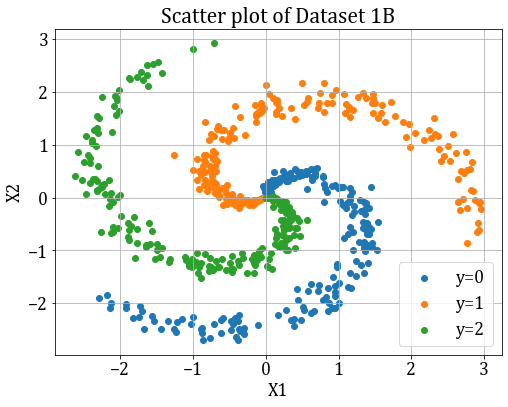

In [3]:
plt.figure()
for i in classes:
    plt.scatter(Xtrain_1[Ytrain==i],Xtrain_2[Ytrain==i],label="y=" + str(int(i)))
plt.legend()
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Scatter plot of Dataset 1B")
plt.savefig("images/data1B_scatter.png")
plt.show()

In [4]:
## Shuffles a provided data set and splits it into cross-validation and test dataset
def create_datasets(data,cv_size):
    data.sample(frac=1).reset_index(drop=True)
    test_size=len(data)-cv_size
    data_test=data[0:test_size]
    data_cv=data[test_size:]
    return(data_cv,data_test)

data1b_cv, data1b_test = create_datasets(data1b_dev, 50)
data1b_test = data1b_test.append(data1b.iloc[595:,:]);

In [5]:
## Calculates accuracy of the model
def accuracy(y_pred,y_actual):
    true_count=0
    for i in range(len(y_pred)):
        if y_pred[i]==y_actual[i]:
            true_count+=1;
    return(true_count/len(y_pred))

In [6]:
## Calculates euclidean distance between two vector points
def euclidean(p1,p2):
    d=np.linalg.norm(np.array(p1)-np.array(p2))
    return d

In [7]:
def knn(x,y,test,k):
    distances=[]
    for i in range(len(x)):
        d=euclidean(x[i],test)
        l=(d,x[i],y[i])
        distances.append(l)
    distances.sort(key = lambda x:x[0])
    count=Counter()
    for i in distances[:k]:
        count[i[2]]+=1
    pred=count.most_common(1)[0][0]
    return(distances[:k],pred)
    

In [8]:
k_list = [1,7,15]
Accuracyknn_cv = []
Accuracyknn_train = []
Accuracyknn_test = []

X_cv = np.array(data1b_cv.drop("y",axis=1))
Y_cv = np.array(data1b_cv["y"])
X_test = np.array(data1b_test.drop("y",axis=1))
Y_test = np.array(data1b_test["y"])

## iterating over k-values
for i in k_list:
    ycv_pred = []
    for j in X_cv:
        ycv_pred.append(knn(Xtrain, Ytrain, j, i)[1])
    ytest_pred = []
    for j in X_test:
        ytest_pred.append(knn(Xtrain, Ytrain, j, i)[1])
    ytrain_pred = []
    for j in Xtrain:
        ytrain_pred.append(knn(Xtrain, Ytrain, j, i)[1])
    
    Accuracyknn_cv.append(accuracy(Y_cv, ycv_pred))
    Accuracyknn_test.append(accuracy(Y_test, ytest_pred))
    Accuracyknn_train.append(accuracy(Ytrain, ytrain_pred))

In [9]:
accuracy_table_KNN = pd.DataFrame(list(zip(k_list, Accuracyknn_train, Accuracyknn_cv, Accuracyknn_test)), columns=["k-value", "Accuracy train", "Accuracy CV", "Accuracy test"])

In [10]:
ytrainpred_1 = []
ytestpred_1 = []
for i in Xtrain:
    ytrainpred_1.append(knn(Xtrain, Ytrain, i, 1)[1])
for i in X_test:
    ytestpred_1.append(knn(Xtrain, Ytrain, i, 1)[1])

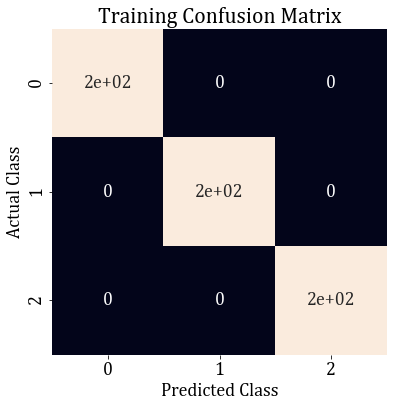

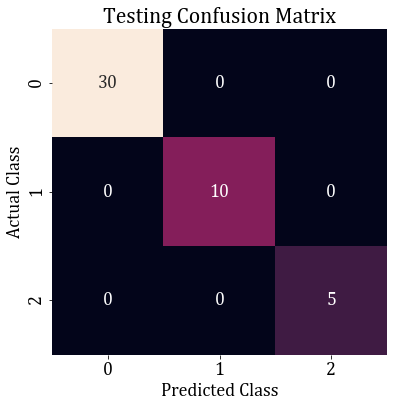

In [11]:
cm_knn_train = confusion_matrix(ytrainpred_1,Ytrain)
plt.figure(figsize=[6,6])
sns.heatmap(cm_knn_train, annot=True, cbar=False)
plt.title("Training Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

cm_knn_test = confusion_matrix(ytestpred_1,Y_test)
plt.figure(figsize=[6,6])
sns.heatmap(cm_knn_test, annot=True, cbar=False)
plt.title("Testing Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

In [12]:
accuracy_table_KNN

,k-value,Accuracy train,Accuracy CV,Accuracy test
0,1,1.000,1.0,1.000000
1,7,0.995,1.0,0.977778
2,15,0.995,1.0,0.977778


## Bayes classifier with KNN to calculate class conditional probabilities

In [13]:
## Seperating the rows by class values
def seperate_by_classval(data):
    ## the target variable must be stored in a column named "y"
    class_vals=list(data["y"].unique())
    seperated=dict()
    features=data.drop('y',axis=1)
    Y=np.array(data["y"])
    ## creates a key value corresponding to each class label
    for i in class_vals:
        seperated[i]=features[Y==i];
    return(seperated)

In [14]:
## Calculates the prior probability of classes and returns a dictionary such that 
## probs[i] is the prior probability of class i
def priori(data):
    seperated_data=seperate_by_classval(data)
    probs=dict()
    for i in seperated_data.keys():
        probs[i]=len(seperated_data[i])/len(data);
    return probs

In [15]:
## Calculates the class-conditional probability p(x/yi) using knn method
## the input x is the data points for a particular class i
## Each row of knn_list consists of a nearest neighbour and its distance from the test point
## prob is the class conditional probability p(x/yi)
def knn_prob(x,test,k):
    distances=[]
    for i in range(len(x)):
        d=euclidean(x[i],test)
        l=(d,x[i])
        distances.append(l)
    distances.sort(key = lambda x:x[0])
    knn_list=distances[:k]
    r=knn_list[-1][0]
    prob=k/(np.pi*r**2*len(x))
    return(knn_list,prob)

In [16]:
## This uses the above code blocks to evaluate p(yi/x) for all the classes
## Returns a dictionary probabs, such that probabs[i] is the p(yi/x)
## also returns label which is the class label corresponding to the maximum p(yi/x) 
def predictor(train_data,k,test_data):
    X_train = seperate_by_classval(train_data)
    p_y = priori(train_data)
    p = 0
    probabs = {}
    for i in list(priori(train_data).keys()):
        p_yi = p_y[i]
        X_traini = X_train[i]
        px_yi = knn_prob(np.array(X_traini),test_data,k)[1]
        pyi_x = px_yi*p_yi
        probabs[i] = pyi_x
        if probabs[i]>p:
            p = probabs[i]
            label = i
            
    sum_vals = sum(list(probabs.values()))
    for i in probabs.keys():
        probabs[i] = probabs[i]/sum_vals
    
    return probabs,label

### Predicting for k=10 and k=20

In [17]:
ypred10_cv = []
ypred10_test = []
ypred20_cv = []
ypred20_test = []
ypred10_train = []
ypred20_train = []

for i in range(len(data1b_cv)):
    ypred10_cv.append(predictor(data1b,10,data1b_cv.iloc[i,:-1])[1])
    ypred20_cv.append(predictor(data1b,20,data1b_cv.iloc[i,:-1])[1])
for i in range(len(data1b_test)):
    ypred10_test.append(predictor(data1b,10,data1b_test.iloc[i,:-1])[1])
    ypred20_test.append(predictor(data1b,20,data1b_test.iloc[i,:-1])[1])
for i in range(len(data1b)):
    ypred10_train.append(predictor(data1b,10,data1b.iloc[i,:-1])[1])
    ypred20_train.append(predictor(data1b,20,data1b.iloc[i,:-1])[1])

In [18]:
accuracy_table = pd.DataFrame()
accuracy_table["k-value"] = [10,20]
accuracy_table["Train data"] = [accuracy(ypred10_train,list(data1b.iloc[:,-1])),accuracy(ypred20_train,list(data1b.iloc[:,-1]))]
accuracy_table["CV data"] = [accuracy(ypred10_cv,list(data1b_cv.iloc[:,-1])),accuracy(ypred20_cv,list(data1b_cv.iloc[:,-1]))]
accuracy_table["Test data"] = [accuracy(ypred10_test,list(data1b_test.iloc[:,-1])),accuracy(ypred20_test,list(data1b_test.iloc[:,-1]))]

In [19]:
accuracy_table

,k-value,Train data,CV data,Test data
0,10,0.991667,1.0,0.955556
1,20,0.986667,1.0,0.933333


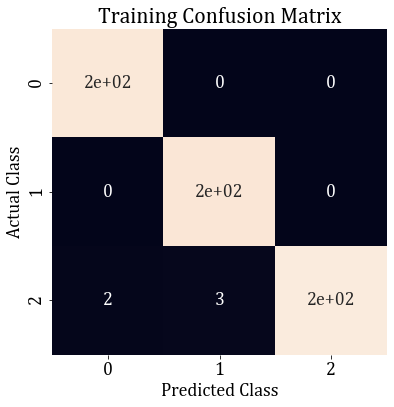

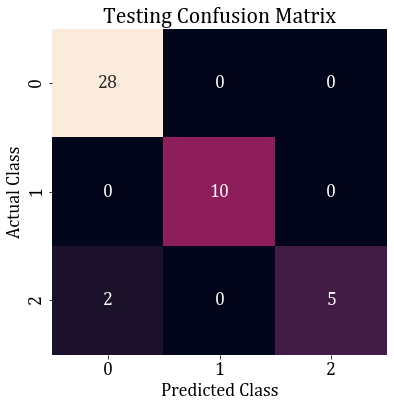

In [20]:
cm_nb_train = confusion_matrix(ypred10_train,Ytrain)
plt.figure(figsize=[6,6])
sns.heatmap(cm_nb_train, annot=True, cbar=False)
plt.title("Training Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

cm_nb_test = confusion_matrix(ypred10_test,Y_test)
plt.figure(figsize=[6,6])
sns.heatmap(cm_nb_test, annot=True, cbar=False)
plt.title("Testing Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

### Decision region plots:

In [21]:
min1,max1 = data1b["x1"].min()-1,data1b["x1"].max()+1
min2,max2 = data1b["x2"].min()-1,data1b["x2"].max()+1

resolution = 0.5
x1grid = np.arange(min1,max1,resolution)
x2grid = np.arange(min2,max2,resolution)

xx,yy = np.meshgrid(x1grid,x2grid)

r1,r2 = xx.flatten(),yy.flatten()
r1,r2 = r1.reshape((len(r1),1)),r2.reshape((len(r2),1))

grid = np.hstack((r1,r2))

In [22]:
yhat_knn = []
for i in range(len(grid)):
    yhat_knn.append(knn(Xtrain,Ytrain,grid[i,:],10)[1])
    
yhat_knn = np.array(yhat_knn)
zz_knn = yhat_knn.reshape(xx.shape)

<Figure size 576x432 with 0 Axes>

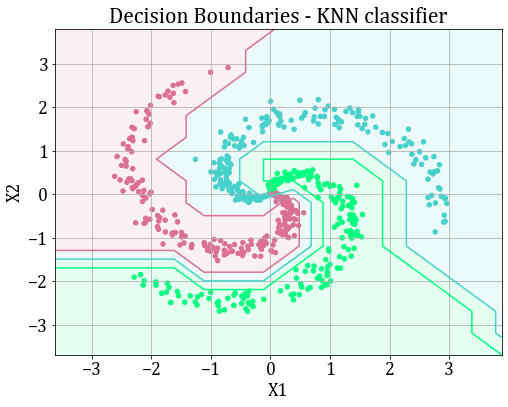

In [23]:
color_list = ["springgreen", "mediumturquoise", "palevioletred"]

plt.figure()
data1b.plot.scatter("x1", "x2", c=[color_list[int(i)] for i in data1b["y"]], alpha=1)
plt.contourf(xx, yy, zz_knn, 2, colors=color_list, alpha=0.1)
plt.contour(xx, yy, zz_knn, 2, colors=color_list, alpha=1)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Decision Boundaries - KNN classifier")
plt.savefig("images/1b_knn_decision_region.png")
plt.show()

In [24]:
yhat_nb = []
for i in range(len(grid)):
    yhat_nb.append(predictor(data1b,10,grid[i,:])[1])
yhat_nb = np.array(yhat_nb)
zz_nb = yhat_nb.reshape(xx.shape)

<Figure size 576x432 with 0 Axes>

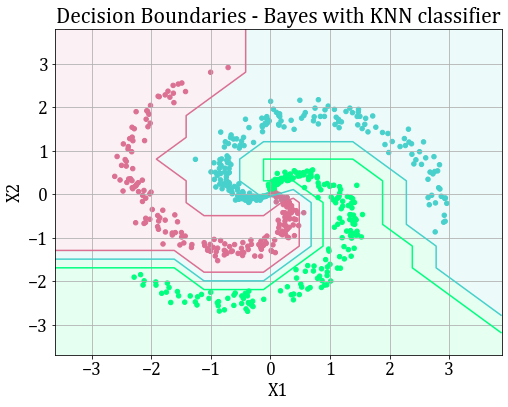

In [25]:
plt.figure()
data1b.plot.scatter("x1", "x2", c=[color_list[int(i)] for i in data1b["y"]], alpha=1)
plt.contourf(xx, yy, zz_nb, 2, colors=color_list, alpha=0.1)
plt.contour(xx, yy, zz_nb, 2, colors=color_list, alpha=1)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Decision Boundaries - Bayes with KNN classifier")
plt.savefig("images/1b_nb_decision_region.png")
plt.show()